# Procedural implementation of univariate Bayesian parameter estimation

In [1]:
%matplotlib notebook

import itertools

import numpy as np
from numpy.testing import assert_approx_equal
import scipy
import matplotlib as mpl
from matplotlib.pyplot import *
from scipy import *
from scipy import stats, special, integrate

try:
    import myplot
    from myplot import close_all, csavefig
    #myplot.tex_on()
    csavefig.save = False
except ImportError:
    pass

---
## Infer a Poisson rate

In [2]:
nlabel = arange(0,25,4)
nlabel

array([ 0,  4,  8, 12, 16, 20, 24])

<IPython.core.display.Javascript object>


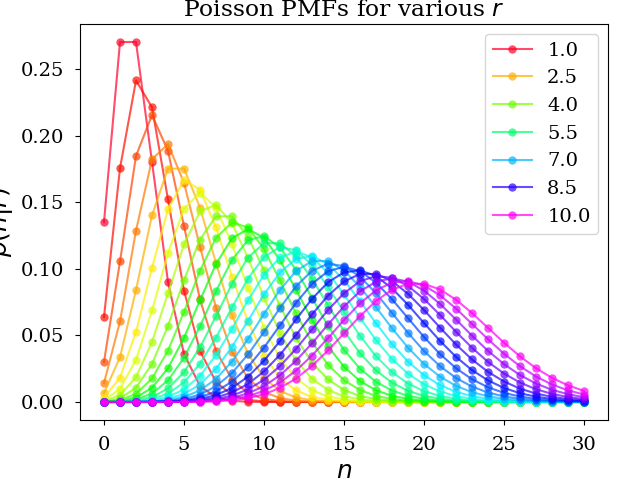

In [3]:
# Show some Poisson PMFs for various rates, T = 2 sec.
T = 2.

rvals = linspace(1., 10., 25)
rlabel = arange(0,25,4)  # index of r values to label for legend
nvals = arange(0,31)

# Cycle through colors across the rainbow:
nc = len(rvals) # give each r value a color
cm = get_cmap('gist_rainbow')
cgen = (cm(1.*i/nc) for i in range(nc))

figure()
for i, (r, c) in enumerate(zip(rvals, cgen)):
    samp_distn = stats.poisson(r*T)  # expected # of counts = r*T
    pmf = samp_distn.pmf(nvals)
    if i in nlabel:
        plot(nvals, pmf, 'o-', mew=0, c=c, alpha=.7, label='{:.1f}'.format(r))
    else:
        plot(nvals, pmf, 'o-', mew=0, c=c, alpha=.7)

xlabel('$n$')
ylabel('$p(n|r)$')
legend()
title('Poisson PMFs for various $r$')

### 1st case:  const prior, $(n,T) = (16, 2)$

<IPython.core.display.Javascript object>


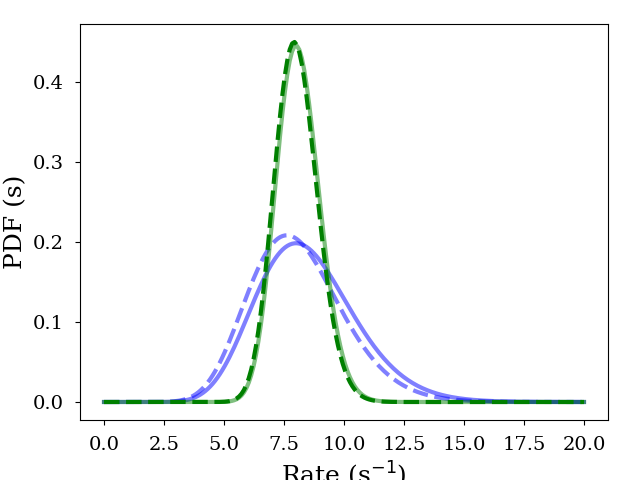

In [4]:
# Parameters specifying the 1st case with a flat prior:
# Make sure prior is proper by bounding it; this choice should not
# depend on the data---it's a *prior*!
prior_l, prior_u = 0., 1e5
n, T = 16, 2.  # data

# Define the grid of rates for computing & plotting.
# A good range will depend on the data; make an educated guess:
r_l, r_u = 0., 20.  #  n/T plus few*sqrt(n)/T
rvals = linspace(r_l, r_u, 200)
rtvals = rvals*T
dr = rvals[1] - rvals[0]

# Bayes's theorem:
prior_pdf = ones_like(rvals)/(prior_u - prior_l)
# Poisson dist'n likelihood, dropping n! factor:
like = (rtvals)**n * exp(-rtvals)
numer = prior_pdf*like
denom = np.trapz(numer, dx=dr)
post_pdf = numer/denom

# Plot the posterior
figure()
plot(rvals, post_pdf, 'b-', lw=3, alpha=0.5)
xlabel(r'Rate (s$^{-1}$)')
ylabel('PDF (s)')

**Test!** The following function is an assertion; in a .py file, it could be used with `nosetests`.

In [5]:
def test_norm(ppdf, delta):
    """
    Test that the posterior is normalized.
    """
    assert_approx_equal(np.trapz(ppdf, dx=delta), 1., 2)  # match 1 to 2 digits

In [6]:
test_norm(post_pdf, dr)

### 2nd case:  exp'l prior with scale (prior mean) 10., $(n,T) = (16, 2)$

In [7]:
# Prior:
scale = 10.
prior = stats.gamma(1, scale=scale)  # a=1 is exp'l dist'n

# Easiest to just copy/paste things that are different this time:

# Bayes's theorem:
numer = prior.pdf(rvals)*like
denom = np.trapz(numer, dx=dr)
post_pdf2 = numer/denom

# Plot both posteriors.
plot(rvals, post_pdf2, 'b--', lw=3, alpha=.5)

# Add these if using `%matplotlib notebook`:
# plot(rvals, post_pdf, 'b-', lw=3, alpha=0.5)
# xlabel(r'Rate (s$^{-1}$)')
# ylabel('PDF (s)')

In [8]:
test_norm(post_pdf2, dr)

### 3rd case:  flat prior with $(n,T) = (80, 10)$

In [9]:
n, T = 80, 10.  # data

# rtvals changes because T changed:
rtvals = rvals*T

# Bayes's theorem:
prior_pdf = ones_like(rvals)/(prior_u - prior_l)
# Poisson dist'n likelihood, dropping n! factor:
like = (rtvals)**n * exp(-rtvals)
numer = prior_pdf*like
denom = np.trapz(numer, dx=dr)
post_pdf3 = numer/denom

plot(rvals, post_pdf3, 'g-', lw=3, alpha=0.5)

In [10]:
test_norm(post_pdf3, dr)

### 4th case:  exp'l prior with scale (prior mean) 10., $(n,T) = (80, 10)$

In [11]:
numer = prior.pdf(rvals)*like
denom = np.trapz(numer, dx=dr)
post_pdf4 = numer/denom

# Plot the posterior
plot(rvals, post_pdf4, 'g--', lw=3)

In [12]:
test_norm(post_pdf4, dr)

---
## Infer a Normal location

In [13]:
def norm_like(data, muvals, sig):
    """
    Evaluate the Normal log-likelihood function for `muvals` (scalar or vector) given
    data values in `data`.  The standard deviation is assumed known, given by `sig`.
    I.e., this ignores `sig`-dependent factors that don't depend on mu.
    """
    muvals = asarray(muvals)
    sig2 = sig*sig
    q = array([sum((data - mu)**2)/sig2 for mu in muvals])
    return exp(-0.5*q)

In [14]:
# Simulate some data:
sig = 3.
mu_t = 5.  # "true" value of mu
samp_distn = stats.norm(mu_t, sig)
n = 20
data = samp_distn.rvs(n)

In [15]:
print data
mean(data)

[  1.92725249   6.64378767   4.56366486   3.29003936   4.57205909
   6.90200379  13.19227336  -1.1589088    4.65516953   1.60233935
   6.81220145   8.69740151   6.58389934   4.83311597   7.63245227
   6.77737436   0.1501686    4.80476595   5.10118554   2.77107928]


5.0176662482857788

<IPython.core.display.Javascript object>


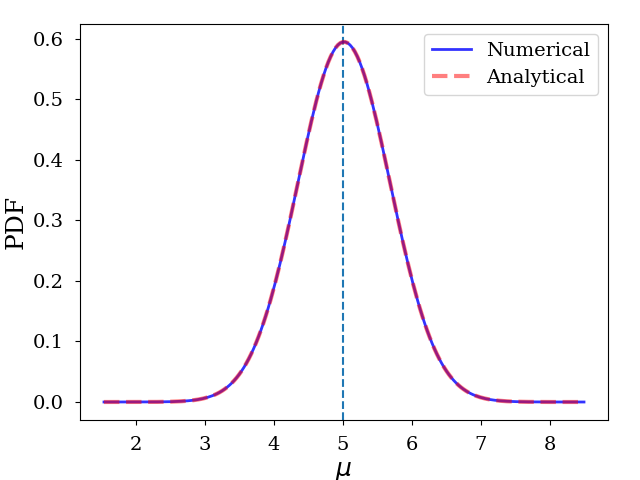

In [16]:
# Prior range for flat prior:
prior_l, prior_u = -100., 100.

# Plot range; this will depend on the data; educated guess:
dbar, dsig = mean(data), std(data)
mu_l = dbar - 5.*dsig/sqrt(n)
mu_u = dbar + 5.*dsig/sqrt(n)

# Define the grid of mus for computing & plotting.
muvals = linspace(mu_l, mu_u, 200)
dmu = muvals[1] - muvals[0]

# Bayes's theorem:
prior_pdf = ones_like(muvals)/(prior_u - prior_l)
like = norm_like(data, muvals, sig)
numer = prior_pdf*like
denom = np.trapz(numer, dx=dmu)
post_pdf = numer/denom

# Plot the posterior
figure()
axvline(mu_t, ls='--')
plot(muvals, post_pdf, 'b-', lw=2, alpha=0.8, label='Numerical')
xlabel('$\mu$')
ylabel('PDF')

# Compare with analytical result for infinite range
post_distn = stats.norm(dbar, sig/sqrt(n))
plot(muvals, post_distn.pdf(muvals), 'r--', lw=3, alpha=0.5, label='Analytical')
legend()

In [17]:
test_norm(post_pdf, dmu)

---
## Infer a Cauchy location

In [18]:
def cauchy_like(data, x0vals, scale):
    """
    Evaluate the Cauchy likelihood function for x0vals (scalar or vector),
    given data values and the Cauchy scale parameter.
    """
    x0vals = asarray(x0vals)  # gives scalars .shape
    scale2 = scale**2
    if len(x0vals.shape) == 0:  # scalar argument -> scalar result
        return prod(1./(1. + (x0vals - data)**2/scale2))
    # Handle vector of x0vals here.
    lvals = empty_like(x0vals)
    for i in range(len(x0vals)):
        lvals[i] = prod(1./(1. + (x0vals[i] - data)**2/scale2))
    return lvals

In [19]:
# Simulate several datasets
scale = 3.
x0 = 5.  # "true" value of x0
n = 5
datasets = []
samp_distn = stats.cauchy(x0, scale)
for i in range(10):
    datasets.append(samp_distn.rvs(n))

# Typical dataset (~median span), treated as both Cauchy and normal:
spans = array( [data.max()-data.min() for data in datasets] )
i = argsort(spans)[len(spans)//2]  # locate ~median
data = datasets[i]

<IPython.core.display.Javascript object>


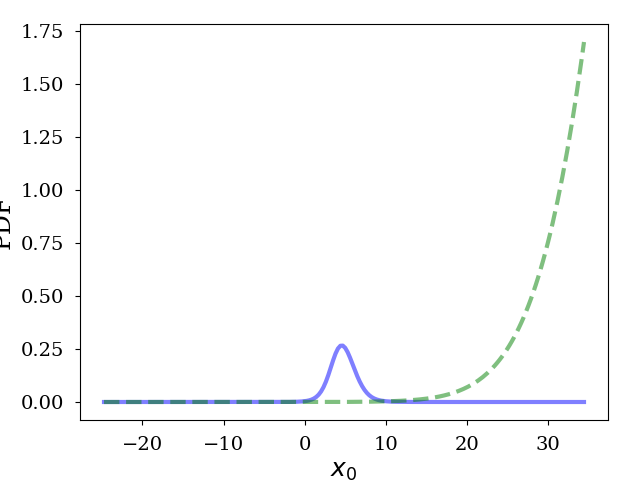

In [20]:
# Prior range for flat prior:
prior_l, prior_u = -100., 100.

# Plot range; this will depend on the data; educated guess:
mid, span = median(data), data.max() - data.min()
x0_l = mid - 2.*span/sqrt(n)
x0_u = mid + 2.*span/sqrt(n)

# Define the grid of x0s for computing & plotting.
x0vals = linspace(x0_l, x0_u, 200)
dx = x0vals[1] - x0vals[0]

# Bayes's theorem:
prior_pdf = ones_like(x0vals)/(prior_u - prior_l)
like = cauchy_like(data, x0vals, scale)
numer = prior_pdf*like
denom = np.trapz(numer, dx=dx)
post_pdf = numer/denom
test_norm(post_pdf, dx)

# Plot the posterior
figure()
plot(x0vals, post_pdf, 'b-', lw=3, alpha=0.5)
xlabel('$x_0$')
ylabel('PDF')

# Pretend the data were normal
if True:
    prior_pdf = ones_like(muvals)/(prior_u - prior_l)
    like = norm_like(data, muvals, sig)
    numer = prior_pdf*like
    denom = np.trapz(numer, dx=dmu)
    post_pdf2 = numer/denom
    plot(x0vals, post_pdf2, 'g--', lw=3, alpha=0.5)

<IPython.core.display.Javascript object>


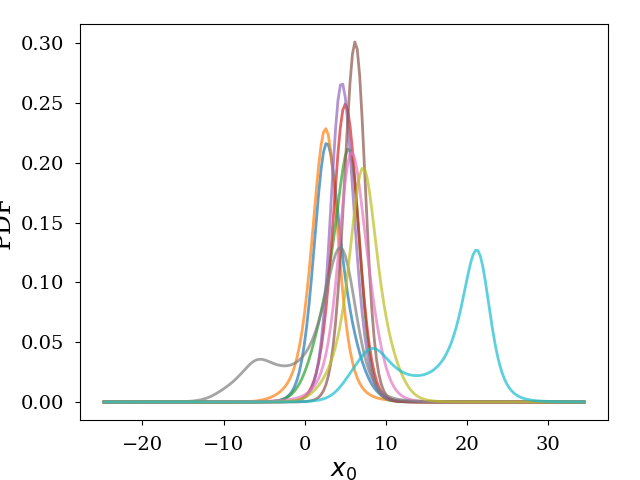

In [21]:
# Plot several posteriors
figure()
for data in datasets:
    like = cauchy_like(data, x0vals, scale)
    numer = prior_pdf*like
    denom = np.trapz(numer, dx=dx)
    post_pdf = numer/denom
    test_norm(post_pdf, dx)

    plot(x0vals, post_pdf, ls='-', lw=2, alpha=0.7)
    xlabel('$x_0$')
    ylabel('PDF')